In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import sys
sys.path.append("..")

from mechanism.mechanized_models import MechanizedGaussianNB
from mechanism.mechanized_models import MechanizedLogisticRegression
from mechanism.mechanized_models import MechanizedDecisionTree




In [5]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [6]:
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [7]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [8]:
training_df = pd.read_csv('../data/Training.csv')
test_df = pd.read_csv('../data/Test.csv')

# Task 1.1

In [9]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 1)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [10]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
relcols

Index(['verified', 'vote', 'R_00', 'R_08', 'R_10 bucks', 'R_12', 'R_15',
       'R_1970', 'R_1970s', 'R_1973',
       ...
       'S_wtf', 'S_year old', 'S_young', 'S_yuck', 'S_yucky', 'S_yuk', 'S_yum',
       'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=4272)

In [12]:
# We will go with these columns.
X = X[relcols]

In [13]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Gaussian NB

In [14]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = GaussianNB()
params_GS = {'var_smoothing': np.logspace(-2, -9, num=10)}
gs_GS = GridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.681 total time=   5.5s
[CV 2/3] END ................var_smoothing=0.01;, score=0.698 total time=   3.6s
[CV 3/3] END ................var_smoothing=0.01;, score=0.709 total time=   3.8s
[CV 1/3] END var_smoothing=0.0016681005372000592;, score=0.753 total time=   3.8s
[CV 2/3] END var_smoothing=0.0016681005372000592;, score=0.759 total time=   3.9s
[CV 3/3] END var_smoothing=0.0016681005372000592;, score=0.780 total time=   3.4s
[CV 1/3] END var_smoothing=0.0002782559402207126;, score=0.730 total time=   3.5s
[CV 2/3] END var_smoothing=0.0002782559402207126;, score=0.760 total time=   3.5s
[CV 3/3] END var_smoothing=0.0002782559402207126;, score=0.788 total time=   3.3s
[CV 1/3] END var_smoothing=4.641588833612772e-05;, score=0.680 total time=   3.5s
[CV 2/3] END var_smoothing=4.641588833612772e-05;, score=0.744 total time=   3.7s
[CV 3/3] END var_smoothing=4.64158883361

KeyboardInterrupt: 

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.7846501883978524
  Accuracy: 0.869475847893114
  ROC/AUC score: 0.7797771736881083
Split 1:
  F1 score: 0.790974276098704
  Accuracy: 0.8806097978759849
  ROC/AUC score: 0.790100414977466
Split 2:
  F1 score: 0.793922378606564
  Accuracy: 0.8747858855772525
  ROC/AUC score: 0.7829463264359233
Split 3:
  F1 score: 0.7835802478866678
  Accuracy: 0.8751284686536485
  ROC/AUC score: 0.7739075571445193
Split 4:
  F1 score: 0.7767782184872329
  Accuracy: 0.8694534863799898
  ROC/AUC score: 0.7704474032119404
Average F1 score: 0.7859810618954042
Average accuracy: 0.8738906972759979
Average ROC/AUC score: 0.7794357750915915


Text(33.0, 0.5, 'True label')

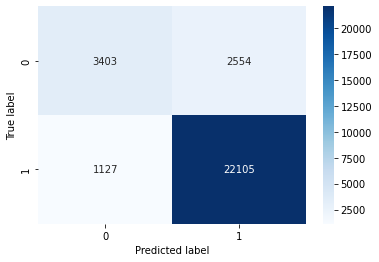

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

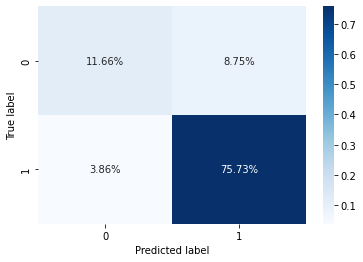

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0016681005372000592)

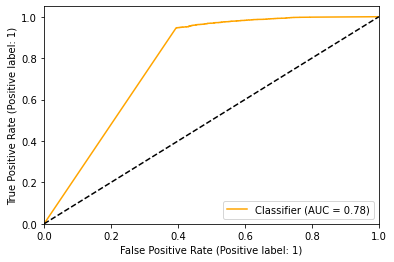

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Logistic Regression

In [41]:
# Hyperparameter selection on one split
# import sys
# sys.path.append("..")

from mechanism.mechanized_models import Mechanism
from sklearn import preprocessing

from mechanism.mechanized_models import MechanizedGridSearchCV


X_train, X_val, y_train, y_val = splits[0]


gs_cls = MechanizedLogisticRegression(max_iter=1500)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_LR = {'C': np.logspace(0.7, 1.1, num=1)}
gs_LR = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=2, verbose=2, scoring='f1_macro')
gs_LR.choose_mechanism(Mechanism.GAUSSIAN)
gs_LR.fit(X_train, y_train)
gs_LR.best_params_

in gaussian mechanism
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ................................C=5.011872336272722; total time=   1.5s
[CV] END ................................C=5.011872336272722; total time=   1.1s


ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/iCloud Drive (Archive)/Documents/.git/AdaptiveAnalysis-jiawen/AdaptivityAnalysis/eval/benchmark/sklearn/mechanized-model/../mechanism/mechanized_models.py", line 45, in fit
    else:
  File "/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1204, in fit
    check_classification_targets(y)
  File "/usr/local/lib/python3.10/site-packages/sklearn/utils/multiclass.py", line 207, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'


In [40]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model

    
    # model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.choose_mechanism(Mechanism.GAUSSIAN)

    
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedLogisticRegression
  F1 score: 0.5866066300139143
  Accuracy: 0.8218568002740665
  ROC/AUC score: 0.8507080441672326
Split 1:
in gaussian mechanism MechanizedLogisticRegression


KeyboardInterrupt: 

Text(33.0, 0.5, 'True label')

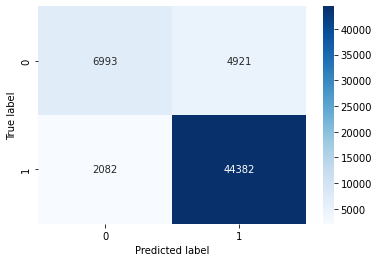

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

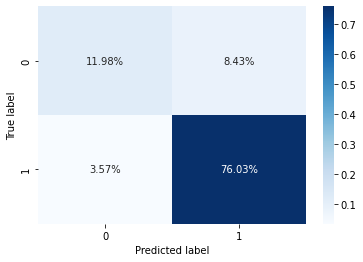

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.fit(X_train, y_train)

LogisticRegression(C=9.261187281287938, max_iter=1500)

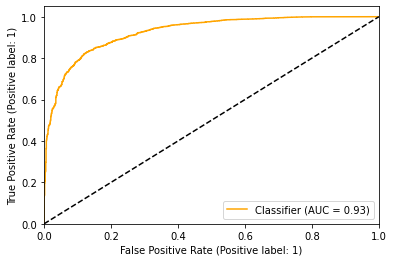

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Decision Tree Classifier

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = DecisionTreeClassifier()
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = GridSearchCV(estimator=gs_cls, param_grid=params_DT, cv=3, verbose=3, scoring='f1_macro')
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...criterion=entropy, max_depth=40;, score=0.673 total time=   3.7s
[CV 2/3] END ...criterion=entropy, max_depth=40;, score=0.681 total time=   3.7s
[CV 3/3] END ...criterion=entropy, max_depth=40;, score=0.690 total time=   3.5s
[CV 1/3] END ...criterion=entropy, max_depth=52;, score=0.673 total time=   3.7s
[CV 2/3] END ...criterion=entropy, max_depth=52;, score=0.688 total time=   4.2s
[CV 3/3] END ...criterion=entropy, max_depth=52;, score=0.699 total time=   4.0s
[CV 1/3] END ...criterion=entropy, max_depth=64;, score=0.675 total time=   4.2s
[CV 2/3] END ...criterion=entropy, max_depth=64;, score=0.692 total time=   4.5s
[CV 3/3] END ...criterion=entropy, max_depth=64;, score=0.701 total time=   4.7s
[CV 1/3] END ...criterion=entropy, max_depth=76;, score=0.682 total time=   4.6s
[CV 2/3] END ...criterion=entropy, max_depth=76;, score=0.695 total time=   5.3s
[CV 3/3] END ...criterion=entropy, max_depth=76;

{'criterion': 'gini', 'max_depth': 76}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = DecisionTreeClassifier(**gs_DT.best_params_)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.6879175908054609
  Accuracy: 0.8119218910585817
  ROC/AUC score: 0.7230355417830155
Split 1:
  F1 score: 0.7071075451819435
  Accuracy: 0.8285371702637889
  ROC/AUC score: 0.7421798127258873
Split 2:
  F1 score: 0.7013471842427343
  Accuracy: 0.8180883864337102
  ROC/AUC score: 0.7204083584015248
Split 3:
  F1 score: 0.7060267469584561
  Accuracy: 0.8302500856457691
  ROC/AUC score: 0.7340232577737513
Split 4:
  F1 score: 0.7024910544553312
  Accuracy: 0.8245674147678602
  ROC/AUC score: 0.7206652169829723
Average F1 score: 0.7646558525695581
Average accuracy: 0.8609178600974919
Average ROC/AUC score: 0.8114289395660063


Text(33.0, 0.5, 'True label')

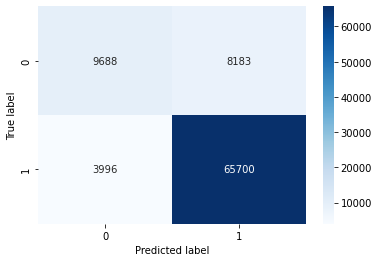

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

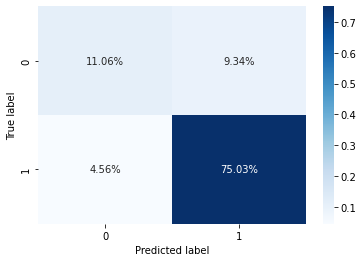

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = DecisionTreeClassifier(**gs_DT.best_params_)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=76)

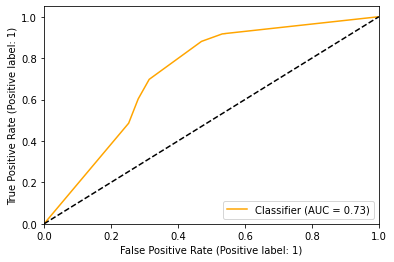

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
model1 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model1.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [ ]:
# # Extra testing
# (X_train, X_val, y_train, y_val) = splits[np.argmax(f1_scores) % 5]
# f1_score(y_val, (model2.predict_proba(X_val) >= 0.7)[:, 1].astype(int), average='macro')

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
# proc_test_df['predicted'] = model1.predict(proc_test_df)
proc_test_df['predicted'] = (model1.predict_proba(proc_test_df) >= 0.7)[:, 1].astype(int) # yields better F1 score!
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task11.csv', index=False)

# Task 1.2

In [ ]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 2)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Gaussian NB

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = GaussianNB()
params_GS = {'var_smoothing': np.logspace(-2, -9, num=10)}
gs_GS = GridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.667 total time=   1.2s
[CV 2/3] END ................var_smoothing=0.01;, score=0.641 total time=   0.9s
[CV 3/3] END ................var_smoothing=0.01;, score=0.677 total time=   0.9s
[CV 1/3] END var_smoothing=0.0016681005372000592;, score=0.756 total time=   0.9s
[CV 2/3] END var_smoothing=0.0016681005372000592;, score=0.756 total time=   0.9s
[CV 3/3] END var_smoothing=0.0016681005372000592;, score=0.787 total time=   0.9s
[CV 1/3] END var_smoothing=0.0002782559402207126;, score=0.760 total time=   0.9s
[CV 2/3] END var_smoothing=0.0002782559402207126;, score=0.767 total time=   0.9s
[CV 3/3] END var_smoothing=0.0002782559402207126;, score=0.806 total time=   0.9s
[CV 1/3] END var_smoothing=4.641588833612772e-05;, score=0.730 total time=   0.9s
[CV 2/3] END var_smoothing=4.641588833612772e-05;, score=0.752 total time=   0.9s
[CV 3/3] END var_smoothing=4.64158883361

{'var_smoothing': 0.0002782559402207126}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.8189320562486069
  Accuracy: 0.8271668379582049
  ROC/AUC score: 0.8349656553296472
Split 1:
  F1 score: 0.8121334300249674
  Accuracy: 0.8208290510448784
  ROC/AUC score: 0.8320448031103385
Split 2:
  F1 score: 0.8166640547618027
  Accuracy: 0.8237410071942446
  ROC/AUC score: 0.8334087321605832
Split 3:
  F1 score: 0.818570815372217
  Accuracy: 0.828708461801987
  ROC/AUC score: 0.8354848096488993
Split 4:
  F1 score: 0.8201116947446008
  Accuracy: 0.8295357204043173
  ROC/AUC score: 0.8332006210302082
Average F1 score: 0.8172824102304389
Average accuracy: 0.8259962156807263
Average ROC/AUC score: 0.8338209242559353


Text(33.0, 0.5, 'True label')

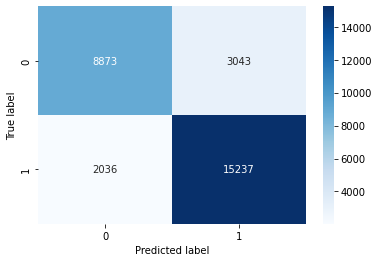

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

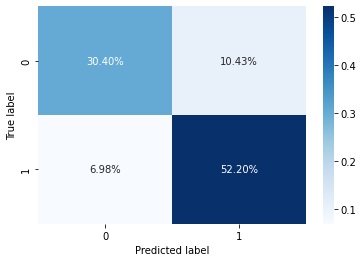

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0002782559402207126)

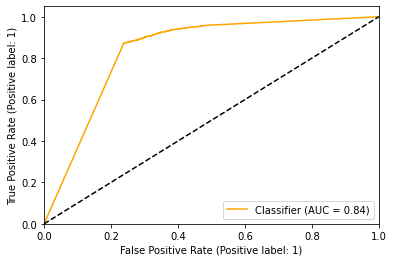

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Logistic Regression

In [39]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = LogisticRegression(max_iter=1500)
params_LR = {'C': np.logspace(0.7, 1.1, num=7)}
gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=3, verbose=3, scoring='f1_macro')
gs_LR.fit(X_train, y_train)
gs_LR.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


KeyboardInterrupt: 

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.8252987366895426
  Accuracy: 0.8329907502569374
  ROC/AUC score: 0.9081659269331246
Split 1:
  F1 score: 0.824705762623679
  Accuracy: 0.8328194587187393
  ROC/AUC score: 0.9096579547490281
Split 2:
  F1 score: 0.823219996881188
  Accuracy: 0.8307639602603631
  ROC/AUC score: 0.9105590904406222
Split 3:
  F1 score: 0.8242859232328297
  Accuracy: 0.8341897910243234
  ROC/AUC score: 0.9081516731685324
Split 4:
  F1 score: 0.8300144682903303
  Accuracy: 0.8386157272571526
  ROC/AUC score: 0.9102304246306236
Average F1 score: 0.8213936938869765
Average accuracy: 0.8299360765921149
Average ROC/AUC score: 0.8715869691201608


Text(33.0, 0.5, 'True label')

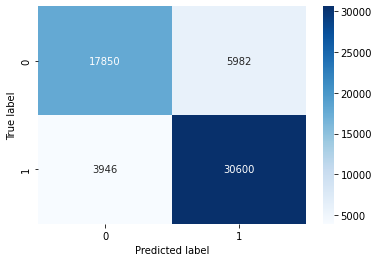

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

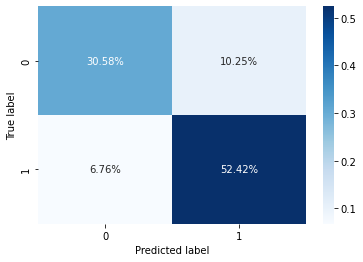

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.fit(X_train, y_train)

LogisticRegression(C=5.011872336272722, max_iter=1500)

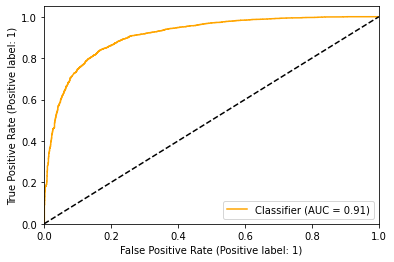

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Decision Tree Classifier

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = DecisionTreeClassifier()
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = GridSearchCV(estimator=gs_cls, param_grid=params_DT, cv=3, verbose=3, scoring='f1_macro')
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...criterion=entropy, max_depth=40;, score=0.669 total time=   4.8s
[CV 2/3] END ...criterion=entropy, max_depth=40;, score=0.694 total time=   4.4s
[CV 3/3] END ...criterion=entropy, max_depth=40;, score=0.688 total time=   4.4s
[CV 1/3] END ...criterion=entropy, max_depth=52;, score=0.664 total time=   4.8s
[CV 2/3] END ...criterion=entropy, max_depth=52;, score=0.661 total time=   5.1s
[CV 3/3] END ...criterion=entropy, max_depth=52;, score=0.691 total time=   7.4s
[CV 1/3] END ...criterion=entropy, max_depth=64;, score=0.671 total time=   5.8s
[CV 2/3] END ...criterion=entropy, max_depth=64;, score=0.670 total time=   5.7s
[CV 3/3] END ...criterion=entropy, max_depth=64;, score=0.687 total time=   5.9s
[CV 1/3] END ...criterion=entropy, max_depth=76;, score=0.670 total time=   5.5s
[CV 2/3] END ...criterion=entropy, max_depth=76;, score=0.672 total time=   6.1s
[CV 3/3] END ...criterion=entropy, max_depth=76;

{'criterion': 'gini', 'max_depth': 40}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = DecisionTreeClassifier(**gs_DT.best_params_)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.712787126555376
  Accuracy: 0.7166837958204865
  ROC/AUC score: 0.7363283136420002
Split 1:
  F1 score: 0.6995770711724503
  Accuracy: 0.7045220966084276
  ROC/AUC score: 0.7197773885550773
Split 2:
  F1 score: 0.6930866541693375
  Accuracy: 0.697499143542309
  ROC/AUC score: 0.7115494006968515
Split 3:
  F1 score: 0.6986868581872935
  Accuracy: 0.7057211373758137
  ROC/AUC score: 0.7191704975397464
Split 4:
  F1 score: 0.7111411387475473
  Accuracy: 0.7166352578379305
  ROC/AUC score: 0.733978614917399
Average F1 score: 0.781947719180118
Average accuracy: 0.7893614798070744
Average ROC/AUC score: 0.822444927103512


Text(33.0, 0.5, 'True label')

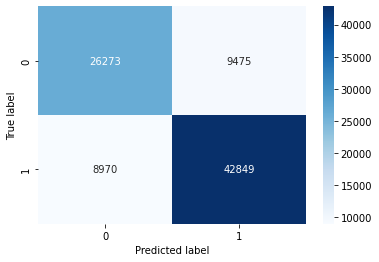

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

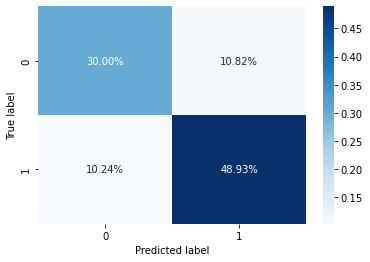

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = DecisionTreeClassifier(**gs_DT.best_params_)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=40)

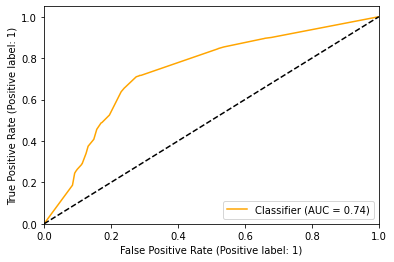

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
model2 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model2.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [ ]:
# # Extra testing
# (X_train, X_val, y_train, y_val) = splits[np.argmax(f1_scores) % 5]
# f1_score(y_val, (model2.predict_proba(X_val) >= 0.54)[:, 1].astype(int), average='macro')

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model2.predict(proc_test_df)
# proc_test_df['predicted'] = (model2.predict_proba(proc_test_df) >= 0.54)[:, 1].astype(int) # yields better F1 score!
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task12.csv', index=False)

# Task 1.3

In [ ]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 3)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Gaussian NB

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = GaussianNB()
params_GS = {'var_smoothing': np.logspace(-2, -9, num=10)}
gs_GS = GridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.768 total time=   1.5s
[CV 2/3] END ................var_smoothing=0.01;, score=0.753 total time=   1.2s
[CV 3/3] END ................var_smoothing=0.01;, score=0.806 total time=   1.1s
[CV 1/3] END var_smoothing=0.0016681005372000592;, score=0.782 total time=   1.1s
[CV 2/3] END var_smoothing=0.0016681005372000592;, score=0.791 total time=   1.1s
[CV 3/3] END var_smoothing=0.0016681005372000592;, score=0.820 total time=   1.1s
[CV 1/3] END var_smoothing=0.0002782559402207126;, score=0.754 total time=   1.1s
[CV 2/3] END var_smoothing=0.0002782559402207126;, score=0.790 total time=   1.1s
[CV 3/3] END var_smoothing=0.0002782559402207126;, score=0.810 total time=   1.1s
[CV 1/3] END var_smoothing=4.641588833612772e-05;, score=0.727 total time=   1.1s
[CV 2/3] END var_smoothing=4.641588833612772e-05;, score=0.762 total time=   1.1s
[CV 3/3] END var_smoothing=4.64158883361

{'var_smoothing': 0.0016681005372000592}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.8391898004477383
  Accuracy: 0.8454950325453923
  ROC/AUC score: 0.8920614416376393
Split 1:
  F1 score: 0.8213463929707884
  Accuracy: 0.8281945871873929
  ROC/AUC score: 0.8794714301417343
Split 2:
  F1 score: 0.8404802002077143
  Accuracy: 0.8468653648509764
  ROC/AUC score: 0.8956045481354081
Split 3:
  F1 score: 0.8252105323324315
  Accuracy: 0.8304213771839671
  ROC/AUC score: 0.8846840313618264
Split 4:
  F1 score: 0.815241799342201
  Accuracy: 0.821140997087545
  ROC/AUC score: 0.8754963861834835
Average F1 score: 0.8282937450601746
Average accuracy: 0.8344234717710547
Average ROC/AUC score: 0.8854635674920184


Text(33.0, 0.5, 'True label')

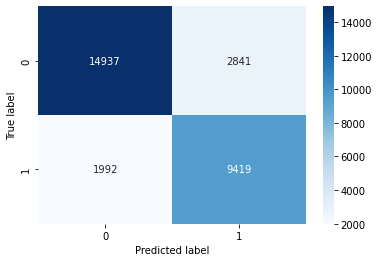

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

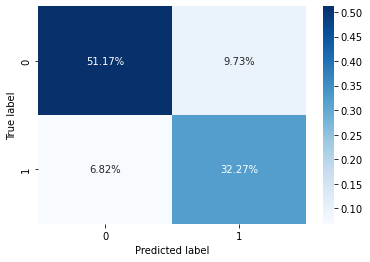

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0016681005372000592)

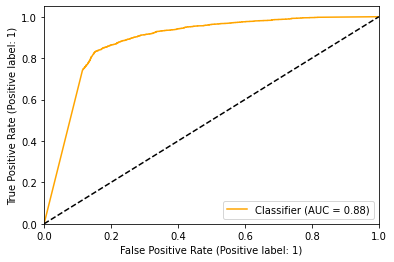

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Logistic Regression

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = LogisticRegression(max_iter=1500)
params_LR = {'C': np.logspace(0.7, 1.1, num=7)}
gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=3, verbose=3, scoring='f1_macro')
gs_LR.fit(X_train, y_train)
gs_LR.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END ...............C=5.011872336272722;, score=0.753 total time=  13.4s
[CV 2/3] END ...............C=5.011872336272722;, score=0.799 total time=  13.8s
[CV 3/3] END ...............C=5.011872336272722;, score=0.814 total time=  12.9s
[CV 1/3] END ...............C=5.843414133735175;, score=0.754 total time=  13.9s
[CV 2/3] END ...............C=5.843414133735175;, score=0.798 total time=  15.7s
[CV 3/3] END ...............C=5.843414133735175;, score=0.814 total time=  16.1s
[CV 1/3] END ...............C=6.812920690579613;, score=0.755 total time=  16.5s
[CV 2/3] END ...............C=6.812920690579613;, score=0.798 total time=  17.8s
[CV 3/3] END ...............C=6.812920690579613;, score=0.813 total time=  18.9s
[CV 1/3] END ...............C=7.943282347242816;, score=0.755 total time=  19.2s
[CV 2/3] END ...............C=7.943282347242816;, score=0.799 total time=  18.5s
[CV 3/3] END ...............C=7.943282347242816;,

{'C': 5.011872336272722}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.8383809865374449
  Accuracy: 0.8480644056183625
  ROC/AUC score: 0.9215711581483395
Split 1:
  F1 score: 0.825373750426246
  Accuracy: 0.8355601233299075
  ROC/AUC score: 0.9139299349361746
Split 2:
  F1 score: 0.839601733357366
  Accuracy: 0.8496060294621446
  ROC/AUC score: 0.9240344841731486
Split 3:
  F1 score: 0.8341693552617145
  Accuracy: 0.842583076396026
  ROC/AUC score: 0.9199483970447963
Split 4:
  F1 score: 0.8283296342185483
  Accuracy: 0.8377591228370739
  ROC/AUC score: 0.9162790997163157
Average F1 score: 0.8307324185102193
Average accuracy: 0.8385690116498787
Average ROC/AUC score: 0.9023080911478868


Text(33.0, 0.5, 'True label')

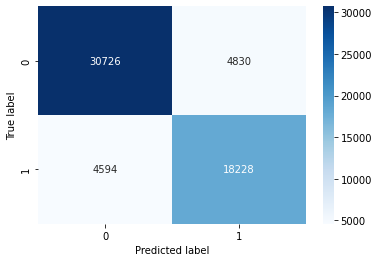

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

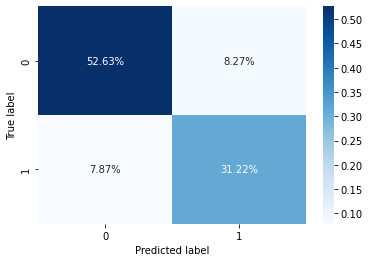

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.fit(X_train, y_train)

LogisticRegression(C=5.011872336272722, max_iter=1500)

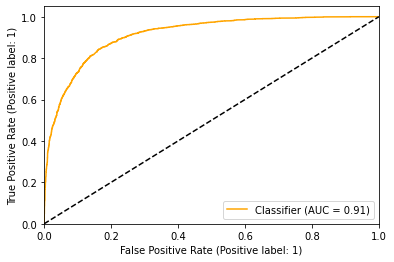

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Decision Tree Classifier

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = DecisionTreeClassifier()
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = GridSearchCV(estimator=gs_cls, param_grid=params_DT, cv=3, verbose=3, scoring='f1_macro')
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...criterion=entropy, max_depth=40;, score=0.642 total time=   4.7s
[CV 2/3] END ...criterion=entropy, max_depth=40;, score=0.687 total time=   4.7s
[CV 3/3] END ...criterion=entropy, max_depth=40;, score=0.681 total time=   5.2s
[CV 1/3] END ...criterion=entropy, max_depth=52;, score=0.649 total time=   5.0s
[CV 2/3] END ...criterion=entropy, max_depth=52;, score=0.691 total time=   5.6s
[CV 3/3] END ...criterion=entropy, max_depth=52;, score=0.678 total time=   5.7s
[CV 1/3] END ...criterion=entropy, max_depth=64;, score=0.649 total time=   5.5s
[CV 2/3] END ...criterion=entropy, max_depth=64;, score=0.692 total time=   6.2s
[CV 3/3] END ...criterion=entropy, max_depth=64;, score=0.684 total time=   5.9s
[CV 1/3] END ...criterion=entropy, max_depth=76;, score=0.651 total time=   5.7s
[CV 2/3] END ...criterion=entropy, max_depth=76;, score=0.690 total time=   6.4s
[CV 3/3] END ...criterion=entropy, max_depth=76;

{'criterion': 'gini', 'max_depth': 76}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = DecisionTreeClassifier(**gs_DT.best_params_)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.6964286545159137
  Accuracy: 0.7166837958204865
  ROC/AUC score: 0.6929747783138203
Split 1:
  F1 score: 0.7075734017935197
  Accuracy: 0.7281603288797533
  ROC/AUC score: 0.6968208232927531
Split 2:
  F1 score: 0.6953663022529277
  Accuracy: 0.7158273381294964
  ROC/AUC score: 0.6825747551393442
Split 3:
  F1 score: 0.6802179453600354
  Accuracy: 0.7019527235354573
  ROC/AUC score: 0.6621711679596989
Split 4:
  F1 score: 0.6940791849663427
  Accuracy: 0.7145794072297413
  ROC/AUC score: 0.6819709005903037
Average F1 score: 0.7853993115993955
Average accuracy: 0.7975262473395816
Average ROC/AUC score: 0.8293062224516525


Text(33.0, 0.5, 'True label')

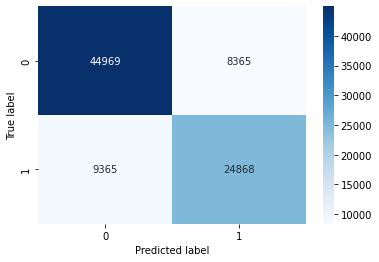

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

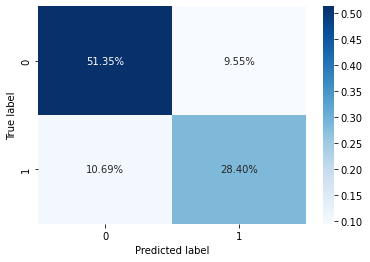

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = DecisionTreeClassifier(**gs_DT.best_params_)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=76)

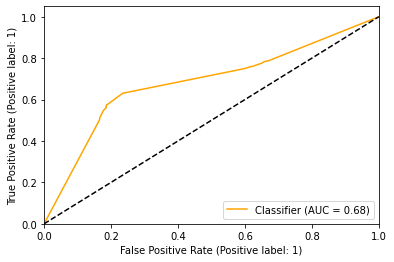

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
# This model seems to perform better on the public test data.
model3 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model3.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model3.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task13.csv', index=False)

# Task 1.4

In [ ]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 4)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Gaussian NB

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = GaussianNB()
params_GS = {'var_smoothing': np.logspace(-2, -9, num=10)}
gs_GS = GridSearchCV(estimator=gs_cls, param_grid=params_GS, cv=3, verbose=3, scoring='f1_macro')
gs_GS.fit(X_train, y_train)
gs_GS.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ................var_smoothing=0.01;, score=0.733 total time=   1.0s
[CV 2/3] END ................var_smoothing=0.01;, score=0.735 total time=   0.9s
[CV 3/3] END ................var_smoothing=0.01;, score=0.743 total time=   0.8s
[CV 1/3] END var_smoothing=0.0016681005372000592;, score=0.738 total time=   0.8s
[CV 2/3] END var_smoothing=0.0016681005372000592;, score=0.742 total time=   0.8s
[CV 3/3] END var_smoothing=0.0016681005372000592;, score=0.760 total time=   0.8s
[CV 1/3] END var_smoothing=0.0002782559402207126;, score=0.730 total time=   0.8s
[CV 2/3] END var_smoothing=0.0002782559402207126;, score=0.718 total time=   0.8s
[CV 3/3] END var_smoothing=0.0002782559402207126;, score=0.747 total time=   0.8s
[CV 1/3] END var_smoothing=4.641588833612772e-05;, score=0.705 total time=   0.8s
[CV 2/3] END var_smoothing=4.641588833612772e-05;, score=0.689 total time=   0.8s
[CV 3/3] END var_smoothing=4.64158883361

{'var_smoothing': 0.0016681005372000592}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.7770344942395944
  Accuracy: 0.8434395340870161
  ROC/AUC score: 0.8850624628922866
Split 1:
  F1 score: 0.7634927233846287
  Accuracy: 0.8398424117848579
  ROC/AUC score: 0.8768812357978785
Split 2:
  F1 score: 0.7790028398820905
  Accuracy: 0.8466940733127784
  ROC/AUC score: 0.8862483791084754
Split 3:
  F1 score: 0.7808686197992506
  Accuracy: 0.8460089071599863
  ROC/AUC score: 0.8876574311931661
Split 4:
  F1 score: 0.7701868959285378
  Accuracy: 0.8393010107932157
  ROC/AUC score: 0.8749223413611781
Average F1 score: 0.7741171146468204
Average accuracy: 0.843057187427571
Average ROC/AUC score: 0.8821543700705968


Text(33.0, 0.5, 'True label')

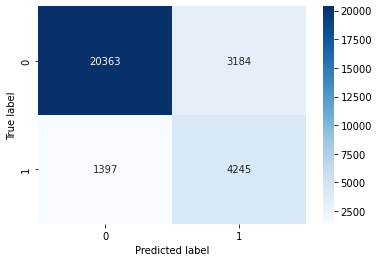

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

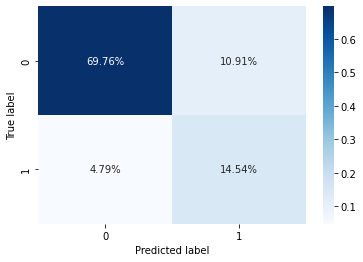

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = GaussianNB(var_smoothing=gs_GS.best_params_['var_smoothing'])
model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0016681005372000592)

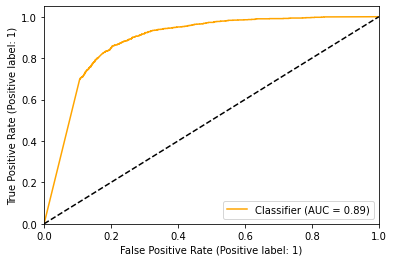

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Logistic Regression

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = LogisticRegression(max_iter=1500)
params_LR = {'C': np.logspace(0.7, 1.1, num=7)}
gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=3, verbose=3, scoring='f1_macro')
gs_LR.fit(X_train, y_train)
gs_LR.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END ...............C=5.011872336272722;, score=0.671 total time=  10.7s
[CV 2/3] END ...............C=5.011872336272722;, score=0.730 total time=  10.1s
[CV 3/3] END ...............C=5.011872336272722;, score=0.729 total time=  11.0s
[CV 1/3] END ...............C=5.843414133735175;, score=0.677 total time=  11.4s
[CV 2/3] END ...............C=5.843414133735175;, score=0.731 total time=  12.5s
[CV 3/3] END ...............C=5.843414133735175;, score=0.730 total time=  11.4s
[CV 1/3] END ...............C=6.812920690579613;, score=0.681 total time=  12.3s
[CV 2/3] END ...............C=6.812920690579613;, score=0.732 total time=  13.3s
[CV 3/3] END ...............C=6.812920690579613;, score=0.732 total time=  13.1s
[CV 1/3] END ...............C=7.943282347242816;, score=0.683 total time=  11.5s
[CV 2/3] END ...............C=7.943282347242816;, score=0.731 total time=  14.7s
[CV 3/3] END ...............C=7.943282347242816;,

{'C': 10.7977516232771}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.7731771856398066
  Accuracy: 0.8723878040424803
  ROC/AUC score: 0.9061957336329776
Split 1:
  F1 score: 0.7552431636948561
  Accuracy: 0.8657074340527577
  ROC/AUC score: 0.9013995567154522
Split 2:
  F1 score: 0.7798873728165618
  Accuracy: 0.8770126755738267
  ROC/AUC score: 0.9100227532885286
Split 3:
  F1 score: 0.7653911750431721
  Accuracy: 0.8660500171291539
  ROC/AUC score: 0.9079985562206043
Split 4:
  F1 score: 0.7602859597912481
  Accuracy: 0.8663697104677061
  ROC/AUC score: 0.8970738599150433
Average F1 score: 0.7704570430219747
Average accuracy: 0.8562813578403778
Average ROC/AUC score: 0.893346231012559


Text(33.0, 0.5, 'True label')

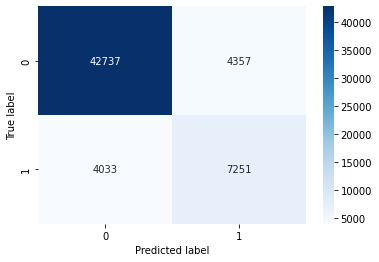

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

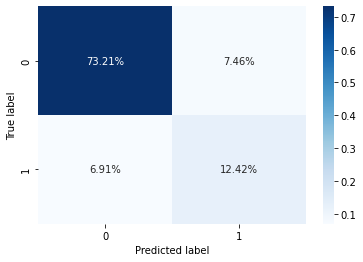

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.fit(X_train, y_train)

LogisticRegression(C=10.7977516232771, max_iter=1500)

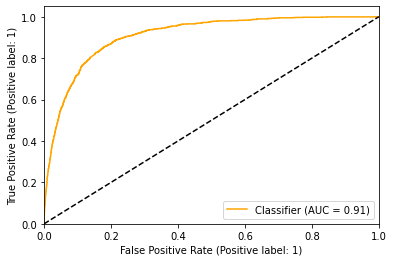

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Decision Tree Classifier

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = DecisionTreeClassifier()
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = GridSearchCV(estimator=gs_cls, param_grid=params_DT, cv=3, verbose=3, scoring='f1_macro')
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...criterion=entropy, max_depth=40;, score=0.605 total time=   3.7s
[CV 2/3] END ...criterion=entropy, max_depth=40;, score=0.657 total time=   3.8s
[CV 3/3] END ...criterion=entropy, max_depth=40;, score=0.639 total time=   3.8s
[CV 1/3] END ...criterion=entropy, max_depth=52;, score=0.627 total time=   3.9s
[CV 2/3] END ...criterion=entropy, max_depth=52;, score=0.641 total time=   4.4s
[CV 3/3] END ...criterion=entropy, max_depth=52;, score=0.637 total time=   4.5s
[CV 1/3] END ...criterion=entropy, max_depth=64;, score=0.624 total time=   4.5s
[CV 2/3] END ...criterion=entropy, max_depth=64;, score=0.656 total time=   4.8s
[CV 3/3] END ...criterion=entropy, max_depth=64;, score=0.643 total time=   4.9s
[CV 1/3] END ...criterion=entropy, max_depth=76;, score=0.623 total time=   4.7s
[CV 2/3] END ...criterion=entropy, max_depth=76;, score=0.647 total time=   5.3s
[CV 3/3] END ...criterion=entropy, max_depth=76;

{'criterion': 'entropy', 'max_depth': 64}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = DecisionTreeClassifier(**gs_DT.best_params_)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.6523665371612433
  Accuracy: 0.8019869818430969
  ROC/AUC score: 0.6626486067196735
Split 1:
  F1 score: 0.6441563090580416
  Accuracy: 0.8004453579993148
  ROC/AUC score: 0.6504445860572645
Split 2:
  F1 score: 0.657025903771099
  Accuracy: 0.8054128126070572
  ROC/AUC score: 0.6803041347365605
Split 3:
  F1 score: 0.6405512532578507
  Accuracy: 0.7944501541623844
  ROC/AUC score: 0.6623286545206735
Split 4:
  F1 score: 0.6464387506364196
  Accuracy: 0.7971560733253383
  ROC/AUC score: 0.6517112034282079
Average F1 score: 0.7296739456069602
Average accuracy: 0.8374843305560646
Average ROC/AUC score: 0.8160599663725313


Text(33.0, 0.5, 'True label')

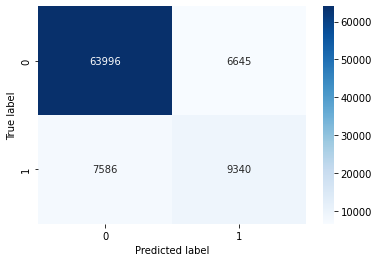

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

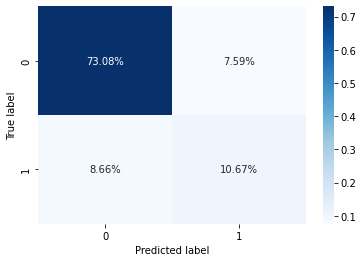

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = DecisionTreeClassifier(**gs_DT.best_params_)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=64)

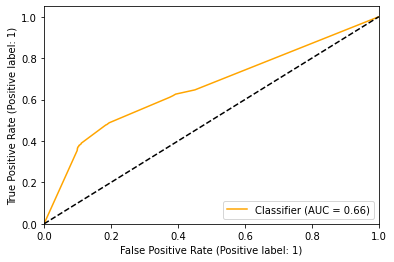

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
# This model seems to perform better on the public test data.
model4 = LogisticRegression(C=10.7977516232771, max_iter=1500)
model4.fit(X, y)

LogisticRegression(C=10.7977516232771, max_iter=1500)

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model4.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task14.csv', index=False)